In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
ROOT_DIR = Path("..").resolve()
import sys
sys.path.insert(0, str(ROOT_DIR))
del sys

from amoeba_segmenter.segmenter import SimpleCystSegmenter

In [4]:
TRAINING_DATA_DIR = ROOT_DIR / "data" / "training"
VALIDATION_DATA_DIR = ROOT_DIR / "data" / "validation"

## Load data

In [35]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
csvs = list((VALIDATION_DATA_DIR / "results").glob("*props.csv"))

In [37]:
data = {}
for csv in csvs:
    name = csv.stem.strip("props")
    d = pd.read_csv(csv, index_col=0)
    data[name] = d

In [38]:
z = np.hstack([d.intensity_mean.values for d in data.values()])

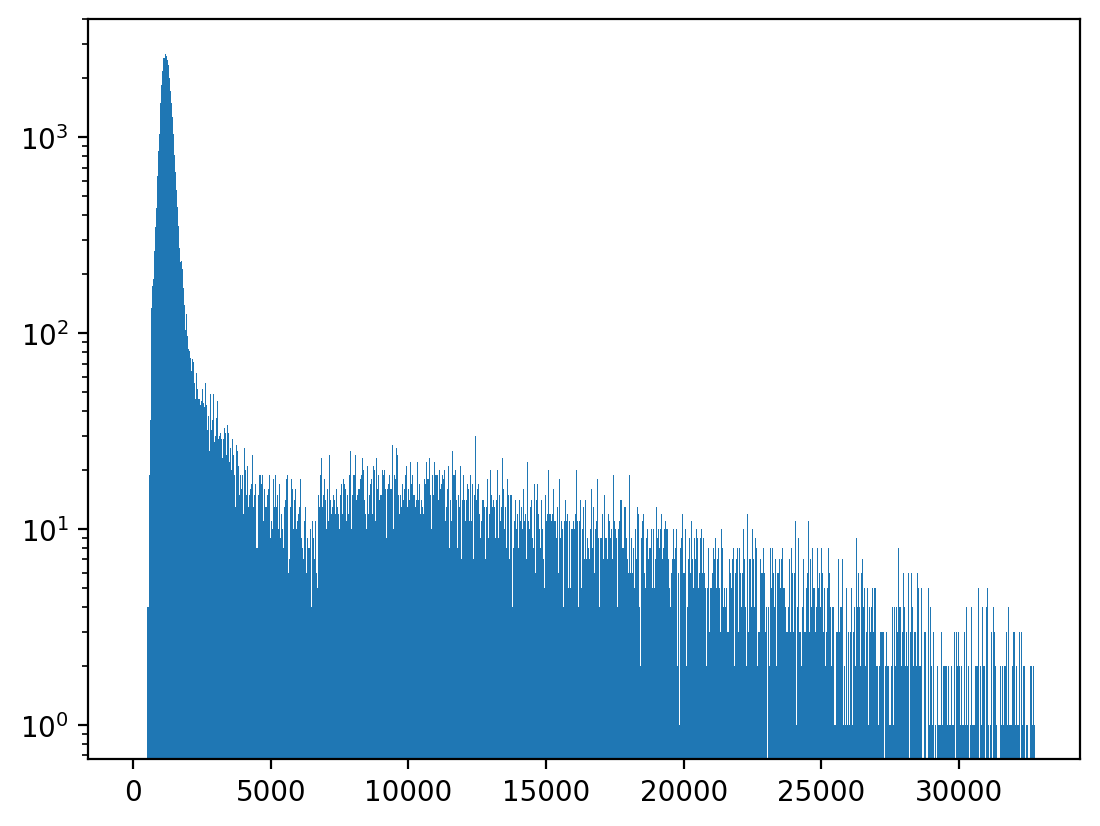

In [39]:
fig, ax = plt.subplots()
ax.hist(z, bins=np.arange(0, 2**15, 10));
ax.set_yscale("log")

In [40]:
series_pat = re.compile(".*_(plate[A-z0-9_]+)\.nd2_([0-9]+).ome.tiff.*")

def recount(name, df, thresh=2500):
    match = series_pat.match(name)
    if not match:
        return
    plate_id, series_id = match.groups()
    series_id = int(series_id) + 1

    total_count = len(df)
    red = df[df.intensity_mean > 2500]
    n_red = len(red)
    #print(plate_id, series_id)

    return pd.DataFrame(
        [[plate_id, series_id, total_count, n_red, n_red / total_count *100]],
        columns=["plate", "series", "total_count", "total_red", "percent_red"]
    )

In [41]:
full_counts = pd.concat(
    [recount(*item) for item in data.items()], axis=0
).set_index(["plate", "series"]).sort_index()

In [42]:
manual_counts = pd.read_csv(VALIDATION_DATA_DIR / "manual_cell_counts.csv")
manual_counts["Plate #"] = "plate" + manual_counts["Plate #"].astype(str)
sorted_manual = manual_counts.set_index(["Plate #", "Microscope picture #"]).sort_index()
sorted_manual.index = sorted_manual.index.rename(["plate", "series"])

In [43]:
full_merged = pd.merge(
    full_counts, sorted_manual, left_index=True, right_index=True
)

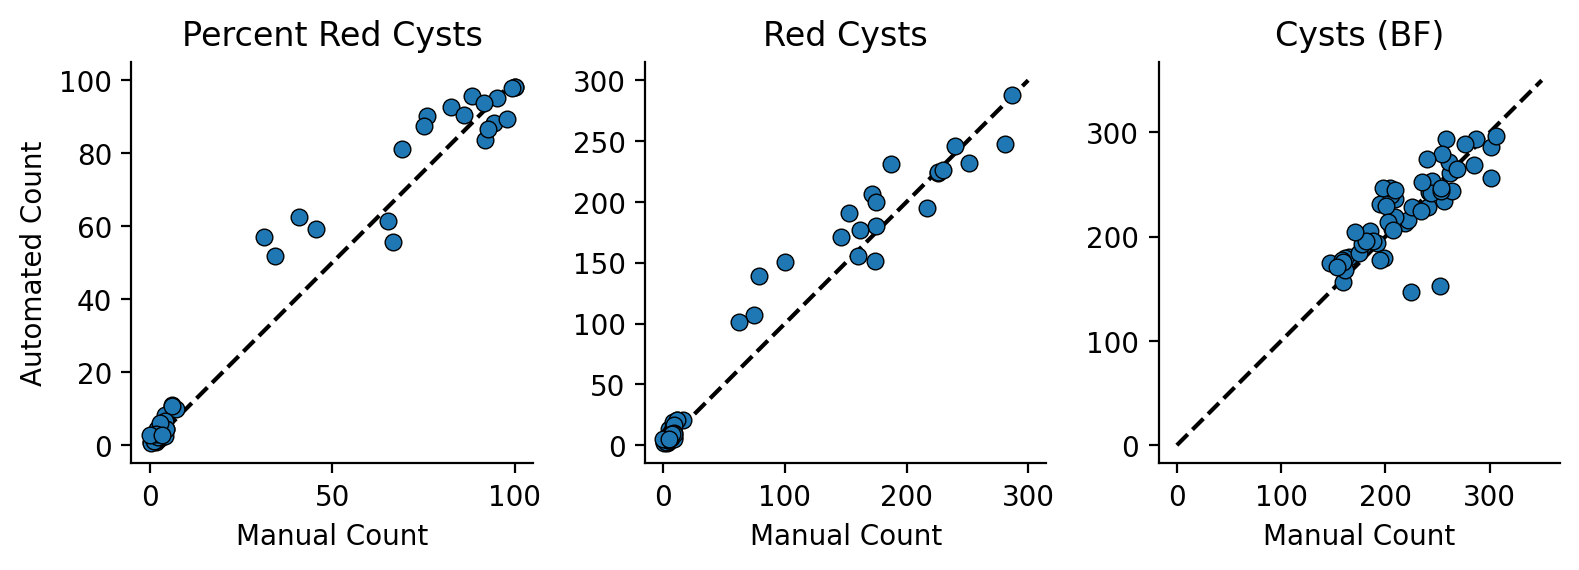

In [45]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 3))
ax0.scatter(full_merged["% cells stained red"], full_merged["percent_red"], lw=0.5, ec="k")
ax0.set_xlabel("Manual Count")
ax0.set_ylabel("Automated Count")
ax0.set_aspect("equal")
ax0.set_title("Percent Red Amoebas")
ax0.plot([0, 100], [0, 100], ls="--", color="k", zorder=-100);

ax1.scatter(full_merged["# red Amoebas (red channel)"], full_merged["total_red"]/4, ec="k", lw=0.5)
ax1.set_xlabel("Manual Count")
ax1.set_aspect("equal")
ax1.set_title("Red Amoebas")
ax1.plot([0, 300], [0, 300], ls="--", color="k", zorder=-100)

ax2.scatter(pd.to_numeric(full_merged["Total # Amoebas (phase image)"], errors="coerce").fillna(154), full_merged["total_count"]/4, ec="k", lw=0.5)
ax2.set_xlabel("Manual Count")
ax2.set_aspect("equal")
ax2.set_title("Amoebas (BF)")
ax2.plot([0, 350], [0, 350], ls="--", color="k", zorder=-100)

fig.tight_layout()
sns.despine(fig)
fig.savefig("validation_manual_vs_auto_v2-multipanel.png", dpi=200)